In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import os.path
from datetime import datetime

env = gym.make('SpaceInvaders-v4')

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
[2017-12-06 01:41:53,688] Making new env: SpaceInvaders-v4


In [2]:
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def preprocess(obs):
    obs = cv2.cvtColor(cv2.resize(obs,(84, 110)), cv2.COLOR_BGR2GRAY)
    obs = obs[26:110,:]
    ret, obs = cv2.threshold(obs,1,255,cv2.THRESH_BINARY)
    return np.reshape(obs, [84,84,1])

In [3]:
class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = 100000
        
    def write(self, data):
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1
        
    def read(self, batch_size):
        return random.sample(self.buffer,min(batch_size,self.length))

In [4]:
class Network:
    
    def __init__(self, session, image_size, n_out):
        
        self.session = session
        self.image_size = image_size
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = n_out
        self.n1 = 16
        self.n2 = 16
        self.n3 = 256
        
        
        self.x = tf.placeholder(tf.float32, [None, self.h, self.w, self.num_channels], name='x')
        self.y = tf.placeholder(tf.float32, [None, self.n_out], name='y')
        self.x_image = tf.reshape(self.x, [-1, self.h, self.w, self.num_channels])
        
        self.W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, self.n1])
        self.b_conv1 = tf.get_variable('b_conv1', shape=[self.n1])
        self.h_conv1 = tf.nn.relu(tf.add(conv(self.x_image, self.W_conv1), self.b_conv1))
        
        self.h_pool1 = maxpool(self.h_conv1)
        
        self.W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, self.n1, self.n2])
        self.b_conv2 = tf.get_variable('b_conv2', shape=[self.n2])
        self.h_conv2 = tf.nn.relu(tf.add(conv(self.h_pool1, self.W_conv2), self.b_conv2))
        
        self.h_pool2 = maxpool(self.h_conv2)
        
        self.h_pool2_flat = tf.reshape(self.h_pool2, [-1, int(self.h/4)*int(self.w/4)*self.n2])
        self.W_fc1 = tf.get_variable('W_fc1', shape=[int(self.h/4)*int(self.w/4)*self.n2, self.n3])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n3])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_pool2_flat, self.W_fc1), self.b_fc1))
        
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n3,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='q_values')
        
        
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
    
    def compute(self, x):
        
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1, self.h, self.w, self.num_channels])})
    
    def train(self, x_batch, y_batch):
        
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})



class Agent: 
    
    def __init__(self, tf_session):
        self.image_size = (84, 84, 1)
        self.h, self.w, self.num_channels = self.image_size
        self.n_out = 6
        
        self.total_reward = 0 
        
        self.gamma = 0.99
        self.epsilon = 1
        self.batch_size = 20
        
        self.replay_buffer = Replay()
        
        self.q = Network(tf_session, self.image_size , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        
        if np.random.rand() > self.epsilon:
            q_compute = self.q.compute(observation)
            return np.argmax(q_compute)
        else:
            return np.random.choice(list(range(6)))
        
    def q_update(self):
        
        sars_batch = self.replay_buffer.read(self.batch_size)
        
        q_last = self.q.compute([s[0] for s in sars_batch])
        
        q_this = np.zeros_like(q_last)
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        
        x_batch = np.zeros([np.shape(sars_batch)[0],self.h, self.w, self.num_channels])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(6):
                if j == sars_batch[i][1]:
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

In [5]:
MODEL_LOG_DIR = './model'
if not os.path.exists(MODEL_LOG_DIR):
    os.makedirs(MODEL_LOG_DIR)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

ep_rewards = []       
agent = Agent(sess)
        
sess.run(tf.global_variables_initializer())      
saver = tf.train.Saver()
        
date_object = datetime.now()
current_time = date_object.strftime('%H:%M:%S')
print("Training starts -- {}".format(current_time))
        
for ep in range(2000): 
            
    last_observation = preprocess(env.reset())
    agent.set_total_reward(0)
    for t in range(10000):
                
        action = agent.choose_action(last_observation)
        observation, reward, done, info = env.step(action)
        observation = preprocess(observation)
                
        if done==True:
            observation = None
                
        agent.gather_reward(reward)
        agent.gather_experience(last_observation, action, reward, observation)
        agent.q_update()
        last_observation = observation
                
        if done==True:
            ep_rewards.append(agent.get_total_reward())
            break
                    
    # print('Episode #{} finished after {} steps, with reward {}'.format(ep+1, t+1, ep_rewards[ep]))
            
    if (ep+1) % 50 == 0:
        date_object = datetime.now()
        current_time = date_object.strftime('%H:%M:%S')
        print('After {} episodes, last 50 rewards averaged {} -- {}'.format(ep+1, np.mean(ep_rewards[-50:]), current_time))
            
    agent.set_epsilon(ep)
            
saver.save(sess, './model/trained_model', global_step=1000)
np.savetxt("{}_rewards.csv".format(ep+1), ep_rewards, delimiter=",")

plt.plot(ep_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Training')
plt.show()

Training starts -- 01:41:55
After 50 episodes, last 50 rewards averaged 160.3 -- 01:53:29
After 100 episodes, last 50 rewards averaged 169.5 -- 02:05:14
After 150 episodes, last 50 rewards averaged 147.9 -- 02:16:37
After 200 episodes, last 50 rewards averaged 151.4 -- 02:28:16
After 250 episodes, last 50 rewards averaged 151.0 -- 02:40:07
After 300 episodes, last 50 rewards averaged 163.9 -- 02:52:53
After 350 episodes, last 50 rewards averaged 162.8 -- 03:05:26
After 400 episodes, last 50 rewards averaged 175.3 -- 03:18:57
After 450 episodes, last 50 rewards averaged 136.7 -- 03:31:03
After 500 episodes, last 50 rewards averaged 154.4 -- 03:43:50
After 550 episodes, last 50 rewards averaged 150.5 -- 03:56:17
After 600 episodes, last 50 rewards averaged 159.5 -- 04:08:42
After 650 episodes, last 50 rewards averaged 166.2 -- 04:21:14
After 700 episodes, last 50 rewards averaged 154.8 -- 04:34:13
After 750 episodes, last 50 rewards averaged 129.4 -- 04:46:19
After 800 episodes, last 50 

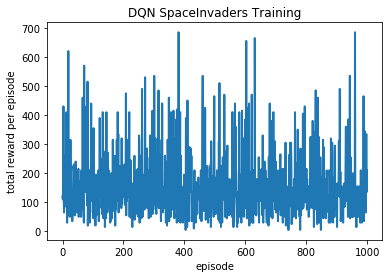

In [11]:
plt.plot(ep_rewards, linewidth=2)
plt.xlabel('episode')
plt.ylabel('total reward per episode')
plt.title('DQN SpaceInvaders Training')
plt.show()